<a href="https://colab.research.google.com/github/IamFaizul/Meet_Faizul/blob/main/ANISOTROPIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [ ]:
full_data = [train,test]
type(full_data)

list

In [ ]:
full_data

[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name     Sex   Age  SibSp  \
 0                              Braund, Mr. Owen Harris    male  22.0      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 2                               Heikkinen, Miss. Laina  female  26.0      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 4                             Allen, Mr. William Henry    male  35.0      0   
 ..                                               

# Feature Engineering ⚡

In [ ]:
# Name

"""
This code creates a new column 'Name_length' in the 'train' DataFrame, and for each row in this new column,
it stores the length (number of characters) of the corresponding 'Name' column. In other words,
it calculates the length of each individual name in the 'Name' column and adds this as a new feature in the dataset.

"""

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)


# Cabin

train['has_cabin'] = train['Cabin'].apply(lambda x:0 if type(x)==float else 1)
test['has_cabin'] = test['Cabin'].apply(lambda x:0 if type(x)==float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

# Feature Selection⚡

In [ ]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [ ]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,has_cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


<Axes: >

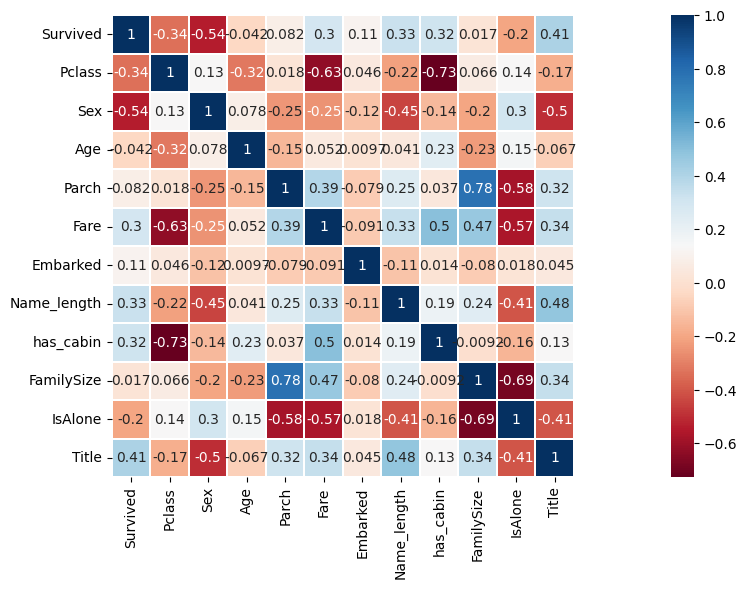

In [ ]:
plt.figure(figsize=(25,6))
sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0,annot=True,linecolor='white',square=True,cmap="RdBu")

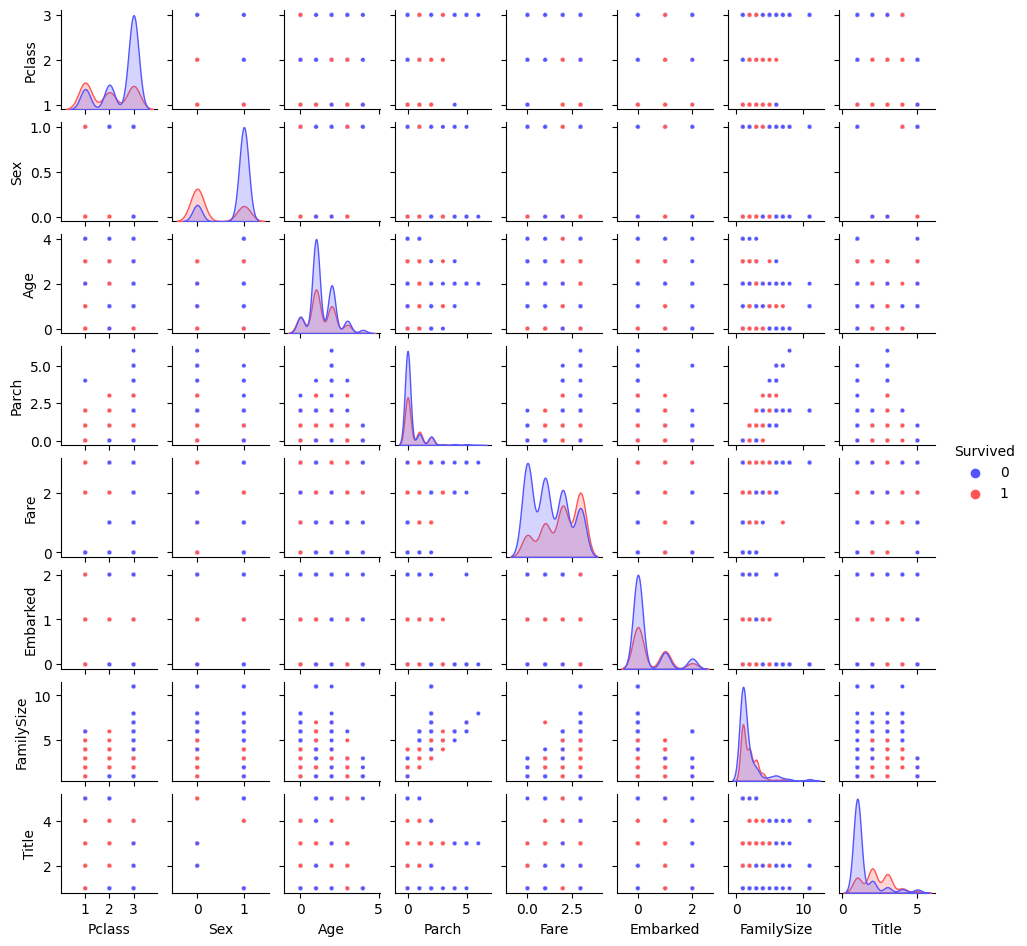

In [ ]:
# Pairplot

sns.pairplot(train[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked','FamilySize', 'Title']],hue='Survived',
             palette='seismic',size=1.2,diag_kind='kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))

**K-fold Cross validation**

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
n_folds = 5  # Number of folds
seed = 0  # Random seed for reproducibility

kf = KFold(n_splits=n_folds,shuffle=True,random_state=seed)

In [ ]:
class library:
    student = "John Doe"
    book = "The subtle art of not giving a fuck"
    def stu(self):
        print(f"Student name is {self.student} and took {self.book}")

student1 = library()
student1.student = 'Mohn Doe'
student1.book = "Eat that frog"
student1.stu()


Student name is Mohn Doe and took Eat that frog


In [ ]:
class Student:
    def __init__(self,name,age,institution):
        self.name = name
        self.age = age
        self.institution = institution
    def information(self):
        print(f"My name is {self.name} and I read in {self.institution}")
person2 = Student('donkey',100,"NSP")
person2.information()

My name is donkey and I read in NSP


In [ ]:
class SklearnHelper:
    def __init__(self,clf,seed,params):
        params['random_state'] = seed
        self.clf(**params)
    def train(self,x_train,y_train):
        self.clf.fit(x_train,y_train)
    def test(self,x):
        return self.clf.predict(x)
    def fit(self,x,y):
        return self.clf.fit(x,y)
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)



**Ashwini Saini**

In [ ]:
df = pd.read_csv("/content/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Importing libraries

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
x = df.drop("Survived",axis=1)
y = df['Survived']

In [ ]:
# Splitting the data

x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

**Radial Support Vector Machine**

In [ ]:
model = svm.SVC(kernel="rbf",C=1,gamma=0.1)
model.fit(x_train,y_train)
prediction = model.predict(x_test)
print(f"The accuracy score is {metrics.accuracy_score(prediction,y_test)}")

**Linear Support Vector Machine**

In [ ]:
model = svm.SVC(kernel="linear",C=1,gamma=0.1)
model.fit(x_train,y_train)
prediction = model.predict(x_test)
print(f"The accuracy score is {metrics.accuracy_score(prediction,y_test)}")

**Logistic Regression**

In [ ]:
model = LogisticRegression()
model.fit(x_train,y_train)
predicition = model.predict(x_test)
print(f"The accuracy score is {metrics.accuracy_score(prediction,y_test)}")

**Decision Tree**

In [ ]:
model = DecisionTreeClassifier()  # It creates an instance
model.fit(x_train,y_train)
predicition = model.predict(x_test)
print(f"The accuracy score is {metrics.accuracy_score(prediction,y_test)}")

**K Nearest Neighbor(KNN)**

In [ ]:
model=KNeighborsClassifier()
model.fit(x_train,y_train)
prediction=model.predict(x_test)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction,y_test))

In [ ]:
index = list(range(1,11))
x = [1,2,3,4,5,6,7,8,9,10]
acc_scores = []
for neighbor in range(1,11):
    model=KNeighborsClassifier()
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    acc_scores.append(prediction)
print(acc_scores)
plt.plot(index,acc_scores)
plt.xticks(x)

**Naive Bayes**

In [ ]:
model=GaussianNB()
model.fit(x_train,y_train)
prediction=model.predict(x_test)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction,y_test))

**Random Forest**

In [ ]:
model=RandomForestClassifier(n_estimators=100)
model.fit(x_train,y_train)
prediction=model.predict(x_test)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction,y_test))

The accuracy of a model is not the only factor that determines the robustness of the classifier. Let's say that a classifier is trained over a training data and tested over the test data and it scores an accuracy of 90%.

Now this seems to be very good accuracy for a classifier, but can we confirm that it will be 90% for all the new test sets that come over??. The answer is No, because we can't determine which all instances will the classifier will use to train itself. As the training and testing data changes, the accuracy will also change. It may increase or decrease. This is known as model variance.

To overcome this and get a generalized model,we use Cross Validation.

# CROSS VALIDATION

Many a times, the data is imbalanced, i.e there may be a high number of class1 instances but less number of other class instances. Thus we should train and test our algorithm on each and every instance of the dataset. Then we can take an average of all the noted accuracies over the dataset.

1)The K-Fold Cross Validation works by first dividing the dataset into k-subsets.

2)Let's say we divide the dataset into (k=5) parts. We reserve 1 part for testing and train the algorithm over the 4 parts.

3)We continue the process by changing the testing part in each iteration and training the algorithm over the other parts. The accuracies and errors are then averaged to get a average accuracy of the algorithm.

This is called K-Fold Cross Validation.

4)An algorithm may underfit over a dataset for some training data and sometimes also overfit the data for other training set. Thus with cross-validation, we can achieve a generalised model.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
kfold = KFold(n_splits=10,random_state=22)  #Split the dtaset into 10 equal parts
cv_mean = []
accuracy = []
cv_std = []
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),
        DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for model in models:
    scores = cross_val_score(model,x,y,cv=kfold,scoring='accuracy')
    mean = cv_mean.append(scores.mean())
    stdev = cv_std.append(scores.std())
    acc = accuracy.append(scores)

cv_df = pd.dataframe({"CV_mean":mean,"CV_std":stdev},index = classifiers)
print(cv_df)

**Confusion Matrix**

In [ ]:
fig,axes = plt.subplots(3,3,figsize=(21,6))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),x,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),ax=axes[0,0],annot=True,fmt='2.0f')
axes[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

**Hyperparameter Tuning**

In [ ]:
# SVM

from sklearn.model_selection import GridSearchCV
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper = {'kernel':kernel,'C':C,'gamma':gamma}
gd = GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
gd.fit(x,y)
print(gd.best_score_)
print(gd.best_estimator_)


In [ ]:
# Random Forest

n_estimator = range(100,1000,100)
hyper = {'n_estimator':n_estimator}
gd = GridSearchCV(estimator=RandomForestClassifier(random_state=42),param_grid=hyper,verbose=True)
gd.fit(x,y)
print(gd.best_score_)
print(gd.best_estimator_)


**Ensemble Learning**

In [ ]:
# SVM

from sklearn.ensemble import VotingClassifier
ens = VotingClassifier(estimator=svm.SVC())